In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline



from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report,classification

/home/anton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv("../data/train.csv")

In [3]:
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

In [4]:
from sklearn.cross_validation import KFold, train_test_split

/home/anton/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
kfold = KFold(15, 3)

In [6]:
for idx in kfold:
    print(idx)

(array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([0, 1, 2, 3, 4]))
(array([ 0,  1,  2,  3,  4, 10, 11, 12, 13, 14]), array([5, 6, 7, 8, 9]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14]))


In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
rf = RandomForestClassifier(100)

In [134]:
rf.fit(X_tr, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [135]:
rf_pred = rf.predict_proba(X_te)

In [136]:
log_loss(y_te, rf_pred)

0.3163935969124363

In [137]:
accuracy_score(y_te, rf_pred[:,0] < 0.5)

0.8664259927797834

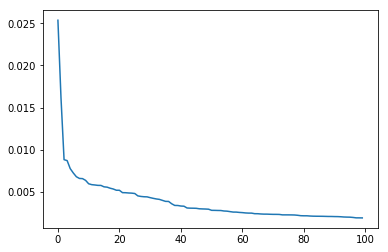

In [138]:
plt.plot(sorted(rf.feature_importances_)[::-1][:100])
plt.show()

In [141]:
rf_feauture_mask = rf.feature_importances_ > 0.002

In [142]:
rf_feauture_mask.sum()

93

In [10]:
X = data[data.columns[:-1]].values
y = data.y.values

In [11]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [12]:
class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}

In [15]:
class_weights

{0.0: 0.2693236714975845, 1.0: 0.7306763285024155}

In [16]:
class WeightLayer:
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [531]:
class DFS:
    def __init__(self, name, input_shape):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')

            self.dense_array = [Dense(256, activation=tf.nn.relu),
                                Dense(256, activation=tf.nn.relu),
                                Dense(2, activation=None)]
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out

    def get_weighted_layer_regularization_term(self, alpha):
        with tf.variable_scope("weighted_layer_regularization"):
            return (1 - alpha) * tf.reduce_sum(tf.abs(self.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(self.weight_layer.w))
        
    def get_dense_layers_regularization_term(self, alpha):
        with tf.variable_scope("dense_layers_regularization"):
            r_term = 0
            for layer in self.dense_array:
                r_term += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))


            return r_term

In [532]:
from keras.layers import Dense

In [547]:
tf.reset_default_graph()
sess = tf.Session()

In [548]:
feature_mask = np.ones(X.shape[1]).astype(bool)
#feature_mask = rf_feauture_mask
n_features = feature_mask.sum()

inp = tf.placeholder(tf.float32, [None, n_features])#X.shape[1]])

dfs = DFS("DFS", n_features)

logits, out = dfs(inp)

In [549]:
target = tf.placeholder(tf.float32, [None])
loss_weights = tf.placeholder(tf.float32, [None])

In [550]:
ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(target, tf.int32), 2), logits, weights=loss_weights)

In [551]:
#regularization_term = 0.001 * tf.reduce_sum(tf.abs(weight_layer.w))

In [552]:
tf.trainable_variables("DFS")

[<tf.Variable 'DFS/wl/w:0' shape=(1524,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/kernel:0' shape=(1524, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/kernel:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'DFS/dense_3/bias:0' shape=(2,) dtype=float32_ref>]

In [553]:
# weighted_layer_regularization = tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# weighted_layer_regularization = 0.05 * weighted_layer_regularization

In [554]:
# regularization = 0#tf.reduce_sum(tf.abs(dfs.weight_layer.w)) + tf.reduce_sum(tf.square(dfs.weight_layer.w))
# for layer in dfs.dense_array:
#     regularization += tf.reduce_sum(tf.abs(layer.weights[0])) + tf.reduce_sum(tf.square(layer.weights[0]))
# regularization = 0.0001 * regularization

In [555]:
loss = ce_loss + 0.1 * dfs.get_weighted_layer_regularization_term(0.5) +  0.0002 * dfs.get_dense_layers_regularization_term(0.5)

In [556]:
optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(loss,var_list=tf.trainable_variables())

In [557]:
sess.run(tf.global_variables_initializer())

In [558]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)

In [516]:
#sess.run(weighted_layer_regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [517]:
#sess.run(regularization,  feed_dict={inp : X_te[:,feature_mask], target: y_te.reshape(-1, 1), loss_weights : val_weights})

In [518]:
sess.run(loss_weights, feed_dict={loss_weights : np.ones(10)})

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [519]:
def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

In [520]:
train_losses = []
train_ce = []
train_r1 = []
train_r2 = []

val_losses = []
val_x = []
n = 5
curr_loss = 0


In [521]:
epochs = 300

In [522]:
zero_weights = []

In [523]:
curr_loss = np.zeros(4)

In [524]:
batch_weights

array([0.26932367, 0.73067633, 0.26932367, 0.73067633, 0.26932367,
       0.73067633, 0.73067633, 0.73067633, 0.73067633, 0.73067633,
       0.73067633, 0.73067633, 0.73067633, 0.73067633, 0.73067633,
       0.73067633, 0.73067633, 0.73067633, 0.73067633, 0.73067633,
       0.73067633, 0.73067633, 0.73067633, 0.73067633, 0.73067633,
       0.73067633, 0.73067633, 0.73067633, 0.26932367, 0.73067633,
       0.73067633, 0.73067633, 0.73067633, 0.73067633, 0.73067633,
       0.26932367, 0.73067633, 0.73067633, 0.73067633, 0.73067633])

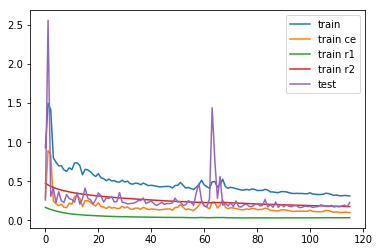

early stop


In [527]:
for epoch in range(epochs):
    for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, 40)):
        batch_weights = np.array([class_weights[y] for y in batch_y])#.flatten()#.reshape(-1,1)

        batch_loss = sess.run([train_step, loss, ce_loss, weighted_layer_regularization, regularization],
                              feed_dict={inp : batch_X[:,feature_mask],
                                         target: batch_y,
                                         loss_weights:batch_weights})
        curr_loss += np.array(batch_loss[1:])
    
    curr_loss /= i
    train_losses.append(curr_loss[0])
    train_ce.append(curr_loss[1])
    train_r1.append(curr_loss[2])
    train_r2.append(curr_loss[3])
    
    curr_loss = np.zeros(4)
          
        
    val_weights = np.array([class_weights[y] for y in y_te])#.reshape(-1,1)
    val_loss = sess.run(ce_loss,  feed_dict={inp : X_te[:,feature_mask], target: y_te, loss_weights : val_weights})
    val_losses.append(val_loss)
    
    display.clear_output(wait=True)
    plt.plot(train_losses[n:], label='train')
    plt.plot(train_ce[n:], label='train ce')
    plt.plot(train_r1[n:], label='train r1')
    plt.plot(train_r2[n:], label='train r2')
    
    plt.plot(val_losses[n:], label='test')
    plt.legend()
    plt.show()
    
    if epoch > 40:
        if np.argmin(np.array(val_losses[-20:])) == 0:
            print("early stop")
            break
            
    
    #zero_weights.append(np.abs(sess.run(weight_layer.w)).min())
        #print(batch_loss[1])

In [480]:
np.array(val_losses[-20:])  

array([0.26797467, 0.32503754, 0.31960326, 0.32971728, 0.33829516,
       0.3634641 , 0.37549177, 0.3775937 , 0.4053882 , 0.41718352,
       0.40912515, 0.39830035, 0.37151688, 0.36609843, 0.3669162 ,
       0.42048326, 0.38938305, 0.40360278, 0.4162744 , 0.4514328 ],
      dtype=float32)

In [481]:
out_ = tf.nn.softmax(out)

In [528]:
pred = (sess.run(out, feed_dict={inp:X_te[:,feature_mask]}) > 0.5).astype(int)[:,1]

print(accuracy_score(y_te, pred))
print(f1_score(y_te, pred))

print(classification_report(y_te, pred))
#print(classification.zero_one_loss(y_te, pred))

mask = y_te < 0.5

print(accuracy_score(y_te[mask], pred[mask]), accuracy_score(y_te[np.logical_not(mask)], pred[np.logical_not(mask)]))

0.7978339350180506
0.8634146341463413
             precision    recall  f1-score   support

        0.0       0.85      0.48      0.61        92
        1.0       0.79      0.96      0.86       185

avg / total       0.81      0.80      0.78       277

0.4782608695652174 0.9567567567567568


In [529]:
y_te

array([0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 1., 0., 0.

In [530]:
pred.flatten().astype(float)

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 0.

In [484]:
importances = sess.run(dfs.weight_layer.w)

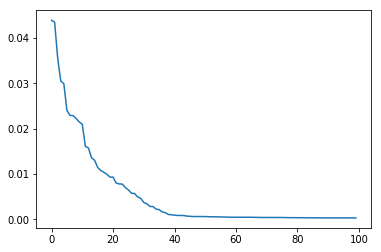

In [485]:
plt.plot(sorted(abs(importances))[::-1][:100])
plt.show()

In [486]:
sorted(abs(importances))[::-1][:60]

[0.043947864,
 0.043517802,
 0.035599638,
 0.03054874,
 0.029942408,
 0.024042096,
 0.022956392,
 0.022902142,
 0.022251979,
 0.021520147,
 0.020994166,
 0.016128628,
 0.015774554,
 0.013611497,
 0.013058648,
 0.011487326,
 0.010807884,
 0.01039926,
 0.0099691935,
 0.009339377,
 0.009335187,
 0.008031922,
 0.007830334,
 0.0077995034,
 0.007034731,
 0.0065056654,
 0.0057725166,
 0.0057263044,
 0.004963694,
 0.0046621305,
 0.0037396562,
 0.00345898,
 0.0028671261,
 0.0028366707,
 0.0022553024,
 0.0021701925,
 0.0016539771,
 0.0015091196,
 0.0010914928,
 0.00103581,
 0.0009411759,
 0.00087193074,
 0.0008696771,
 0.0008650388,
 0.0007399394,
 0.0006875464,
 0.000637955,
 0.0006377594,
 0.00063691364,
 0.00063677575,
 0.0006332269,
 0.00060557656,
 0.00058413035,
 0.00057808944,
 0.000575044,
 0.0005419304,
 0.00053618243,
 0.00049996027,
 0.0004913056,
 0.0004888583]